# Bangla Handwritten Digit Recognition using Keras

#### We first download and unzip the NumtaDB dataset by Bengali.ai team which consists of 72K train image and 17.5K test image set. It is a revolutionary dataset for Bangla handwritten digit recognition as it has a wide range of images fro different distributions. 

In [0]:
 !wget https://bengali.ai/wp-content/uploads/datasets/NumtaDB_with_aug.zip -P drive/numta

In [0]:
cd drive/numta

In [0]:
!unzip NumtaDB_with_aug.zip

In [0]:
!pip install git+https://github.com/aleju/imgaug

#### Next we import various modules for deep learning framework Keras, plotting of images, and 'imgaug' module for image augmentation.

In [0]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import layer_utils, plot_model
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.initializers import glorot_uniform
from __future__ import print_function
import keras
from keras import backend as k
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage
import six
import scipy
from imgaug import augmenters as iaa

## Step 1: Load and Process the data

**We extract all the train and test image paths and put them in separate variables.**

In [0]:
RESIZE_DIM = 48 # The images will be resized to 28x28 pixels
CHANNELS = 1
data_dir=os.path.join('')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')


In [0]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key


def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)
    

def get_data(paths_img,path_label=None,resize_dim=None):
 
    X=[] 
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_COLOR) 
        img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # cnahging colorspace to GRAY
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) 
 
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y


**Next we are going to use the `get_data()` function to load and process all the images from dataset **

In [10]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_a[0].shape,X_train_all.shape, y_train_all.shape


processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


((48, 48), (72045, 48, 48), (72045, 10))

In [11]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))
X_test_all.shape

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


(17626, 48, 48)

**Here are some visualizzation of sample Bangla digit images.**

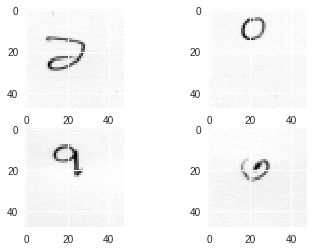

In [13]:
X_show_all=X_train_all
X_tshow_all=X_test_all

plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

##Step 2: Data Preprosessing

**We make use of the imgaug library to augment our images in order to replicate the distribution of the test set images. This library allows to modify images in a flexible way.**

In [14]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],RESIZE_DIM, RESIZE_DIM,CHANNELS)
#X_train_b = X_train_b.reshape(X_train_b.shape[0],RESIZE_DIM, RESIZE_DIM,CHANNELS)

def img_func(images, random_state, parents, hooks):
    for img in images:
        img[::10] = 150
    return images

def keypoint_func(keypoints_on_images, random_state, parents, hooks):
    return keypoints_on_images

xx = np.concatenate((X_train_a, X_train_c), axis=0)
yy = np.concatenate((y_train_a, y_train_c), axis=0)
xx = xx.reshape(xx.shape[0], RESIZE_DIM, RESIZE_DIM, CHANNELS)  

#auggg = iaa.Sometimes(0.001, iaa.Lambda(img_func , keypoint_func))
#aug = iaa.Lambda(img_func, keypoint_func)
aug = iaa.SomeOf((1, 5), [
    iaa.GaussianBlur(sigma=(0.3, 1)),
    iaa.AddElementwise((0, 75)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.07*255)),
    iaa.Multiply((0.5, 1.5)),
    iaa.Dropout(p=(0, 0.1)),
    iaa.Invert(0.5),
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Affine(shear=(-30, 30), mode=['constant', 'edge']),
    iaa.Affine(scale=(0.7, 1.3), mode=['constant', 'edge']),
    iaa.Affine(scale={"x": (0.6, 1.3), "y": (0.6, 1.3)}, mode=['constant', 'edge']),
    iaa.Affine(translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)}, mode='edge'),
    iaa.Affine(rotate=(-45, 45)),
    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    iaa.CropAndPad(
        percent=(0, 0.2),
        pad_mode=["edge"],
    ),
    iaa.Sequential([
       #iaa.AddElementwise((0, 80))
       iaa.Affine(scale=(1.5)),
       iaa.CoarseDropout((0.08), size_percent=(0.24)),
       iaa.Affine(scale=(0.85), mode=["edge"])
    ], random_order=False),
    
    iaa.Sequential([
       iaa.Affine(scale=(0.83)),
       iaa.Affine(rotate=(-45, 45))
    ], random_order=False)


], random_order=True)

augg = iaa.SomeOf((1, 2), [
    iaa.GaussianBlur(sigma=(0.0, 1.35)),
    iaa.AverageBlur(3),
    iaa.AddElementwise((0, 20)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.07*255)),
    iaa.Multiply((0.5, 1.5)),
    iaa.Dropout(p=(0, 0.12)),
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Affine(shear=(-25, 25), mode=['constant', 'edge']),
    iaa.Affine(scale=(0.7, 1.3), mode=['constant', 'edge']),
    iaa.Affine(scale={"x": (0.5, 1.3), "y": (0.5, 1.3)}, mode=['constant', 'edge']),
    iaa.Affine(translate_percent={"x": (-0.20, 0.20), "y": (-0.20, 0.20)}, mode='edge'),
    iaa.CropAndPad(
        percent=((0,0.3),(0,0.3),(0,0.3),(0,0.3)),
        pad_mode=["edge"],
    )
    ,
    iaa.Sequential([
       #iaa.AddElementwise((0, 80))
       iaa.Affine(scale=(1.5)),
       iaa.CoarseDropout((0.08), size_percent=(0.24)),
       iaa.Affine(scale=(0.85), mode=["edge"])
    ], random_order=False),
    
    iaa.Sequential([
       iaa.Affine(scale=(0.83)),
       iaa.Affine(rotate=(-60, 60))
    ], random_order=False)


], random_order=True)

new_images1 = aug.augment_images(xx)
new_images2 = augg.augment_images(xx)


X_train_all = np.concatenate((X_train_all,new_images1, new_images2), axis=0)
y_train_all = np.concatenate((y_train_all,yy, yy), axis=0)
print("Processing Done. matrix size: ", X_train_all.shape, y_train_all.shape)
  
#X_train_all = auggg.augment_images(X_train_all)
X_train_all.shape

Processing Done. matrix size:  (160045, 48, 48, 1) (160045, 10)


(160045, 48, 48, 1)

In [0]:
import random
i = 0
while i < 16000:
  j = random.randint(0,160044)
  one = random.randint(20,29)
  two = one - 16
  three = one + 16
  for k in range(48):
    if k % 3 == 0:
      X_train_all[j,one,k,0] = 60
      X_train_all[j,two,k,0] = 60 
      X_train_all[j,three,k,0] = 60
  i+=1
      

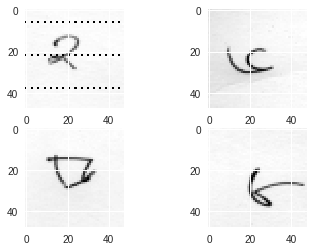

In [24]:
X_temp = X_temp.reshape(X_temp.shape[0],RESIZE_DIM, RESIZE_DIM)
plt.subplot(221)
plt.imshow(X_temp[random.randint(0,1600)], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_temp[random.randint(0,1600)], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_temp[random.randint(0,1600)], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_temp[random.randint(0,1600)], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

**Next we normalize the images and divide the whole train set into separate train and validation set.**

In [39]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],RESIZE_DIM, RESIZE_DIM,CHANNELS).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],RESIZE_DIM, RESIZE_DIM,CHANNELS).astype('float32')
X_train_all = np.rollaxis(X_train_all, 3, 1)
X_test_all = np.rollaxis(X_test_all, 3, 1)
X_train_all = X_train_all/255
X_test_all = X_test_all/255

indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.85)
# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

X_train_all.shape, y_train_all.shape

((160045, 1, 48, 48), (160045, 10))

## Step 3: Design the model



**We used Keras to design our deep learning model. We used custom Convolutional Neural Network which gives state of the art result without using too many layers.**

In [0]:
def customm(img_size=RESIZE_DIM, channels=1):
    model = Sequential()
    input_shape = (img_size, img_size, channels)
    model.add(Conv2D(32, (5,5), input_shape=input_shape, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(Conv2D(32, (5,5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model
    

## Step 3: Train the model

**After designing our model we now train the model with checkpoints and dynamic learning rate for appropriate epochs to get a decent accuracy. **

In [0]:

K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one

model = customm() 
#model.summary()
#model = load_model('demo_model.hdf5')
K.set_value(model.optimizer.lr,0.001) # set the learning rate
batch_size=64
model_check_point = ModelCheckpoint(filepath='demo_model.hdf5', save_best_only=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
X_train_all.shape
# fit the model
h=model.fit(x=X_train,y=y_train, batch_size=batch_size,
            epochs=25,
            #steps_per_epoch=X_train.shape[0] // batch_size,
            verbose=1,          
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[learning_rate_reduction,model_check_point]
            )


**Finally we save the prediction of the test set images predicted by the trained model in a csv file. **

In [0]:
model = load_model('demo_model.hdf5')
predictions_prob=model.predict(X_test_all)
labels=[np.argmax(pred) for pred in predictions_prob]
keys=[get_key(path) for path in paths_test_all ]
create_submission(predictions=labels,keys=keys,path='pred.csv')